<a href="https://colab.research.google.com/github/ashray-00/Art-Generation-with-Neural-Style-Transfer/blob/main/CNN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np
import tarfile
import warnings
import sys, os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.models import model_from_json
import itertools
from sklearn.metrics import confusion_matrix
import cv2

In [36]:
warnings.filterwarnings("ignore")
with tarfile.open('/content/fer2013.tar.gz', "r:*") as tar:
  csv_path = tar.getnames()[0]
  data = pd.read_csv(tar.extractfile(csv_path))
  
width, height = 48, 48

datapoints = data['pixels'].tolist()

  #get features for training
X = []
for xseq in datapoints:
  xx = [int(xp) for xp in xseq.split(' ')]
  xx = np.asarray(xx).reshape(width, height)
  X.append(xx.astype('float32'))

In [37]:
X = np.asarray(X)
X = np.expand_dims(X, -1)

y = pd.get_dummies(data['emotion']).values

np.save('fdataX', X)
np.save('flabels', y)

print("Completed Preprocessing")
print("Number of Features:" + str(len(X[0])))
print("Number of labels:" + str(len(y[0])))
print("Number of examples in dataset:" + str(len(X)))
print("X,y storedd in fdataX.npy and flabels.npy respectively")

Completed Preprocessing
Number of Features:48
Number of labels:7
Number of examples in dataset:35887
X,y storedd in fdataX.npy and flabels.npy respectively


[0 0 0 1 0 0 0]


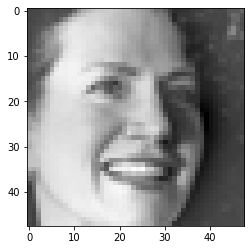

[1 0 0 0 0 0 0]


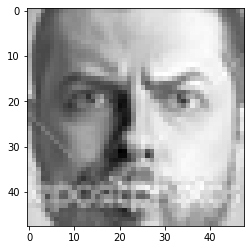

[1 0 0 0 0 0 0]


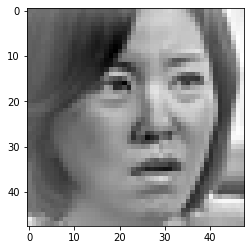

In [38]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

x = np.load('fdataX.npy')
y = np.load('flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

for xx in range(247,250):
  plt.figure(xx)
  plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
  print(y[xx])
  plt.show()

#splitting data into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

# Save testing data to be used later
np.save('modXtest', X_test)
np.save('modytest', y_test)

In [39]:
# Designing the CNN
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 23, 23, 128)      

In [40]:
# Now compiling the model with adam optimizer and categorial crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

#training the model
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs = epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

fer_json = model.to_json()
with open("fer.json", "w") as json_file:
  json_file.write(fer_json)
model.save_weights("fer.h5")
print("Saved model")

Epoch 1/100
455/455 [==============================] - 21s 43ms/step - loss: 2.2913 - accuracy: 0.2037 - val_loss: 1.8211 - val_accuracy: 0.2594
Epoch 2/100
455/455 [==============================] - 19s 43ms/step - loss: 1.8385 - accuracy: 0.2375 - val_loss: 1.8078 - val_accuracy: 0.2607
Epoch 3/100
455/455 [==============================] - 20s 43ms/step - loss: 1.7806 - accuracy: 0.2779 - val_loss: 1.6571 - val_accuracy: 0.3235
Epoch 4/100
455/455 [==============================] - 20s 43ms/step - loss: 1.6773 - accuracy: 0.3252 - val_loss: 1.5830 - val_accuracy: 0.3830
Epoch 5/100
455/455 [==============================] - 20s 44ms/step - loss: 1.5456 - accuracy: 0.3879 - val_loss: 1.3962 - val_accuracy: 0.4378
Epoch 6/100
455/455 [==============================] - 20s 44ms/step - loss: 1.4717 - accuracy: 0.4199 - val_loss: 1.3431 - val_accuracy: 0.4759
Epoch 7/100
455/455 [==============================] - 20s 44ms/step - loss: 1.4229 - accuracy: 0.4459 - val_loss: 1.2935 - val_ac

In [47]:
def test():
    json_file = open('fer.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("fer.h5")
    print("Loaded model from disk")
    truey=[]
    predy=[]
    x = np.load('./modXtest.npy')
    y = np.load('./modytest.npy')
    
    yhat= loaded_model.predict(x)
    yh = yhat.tolist()
    yt = y.tolist()
    count = 0
    
    for i in range(len(y)):
        yy = max(yh[i])
        yyt = max(yt[i])
        predy.append(yh[i].index(yy))
        truey.append(yt[i].index(yyt))
        if(yh[i].index(yy)== yt[i].index(yyt)):
            count+=1
    
    acc = (count/len(y))
    
    #saving values for confusion matrix and analysis
    np.save('truey', truey)
    np.save('predy', predy)
    print("Predicted and true label values saved")
    print("Accuracy on test set :"+str(acc)+"%")

In [48]:
test()

Loaded model from disk
Predicted and true label values saved
Accuracy on test set :0.647255502925606%


In [49]:
def confusion(model):
    y_true = np.load('./truey.npy')
    y_pred = np.load('./predy.npy')

    # compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

  # plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=labels, title='Normalized confusion matrix')
    plt.show()


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

<Figure size 432x288 with 0 Axes>

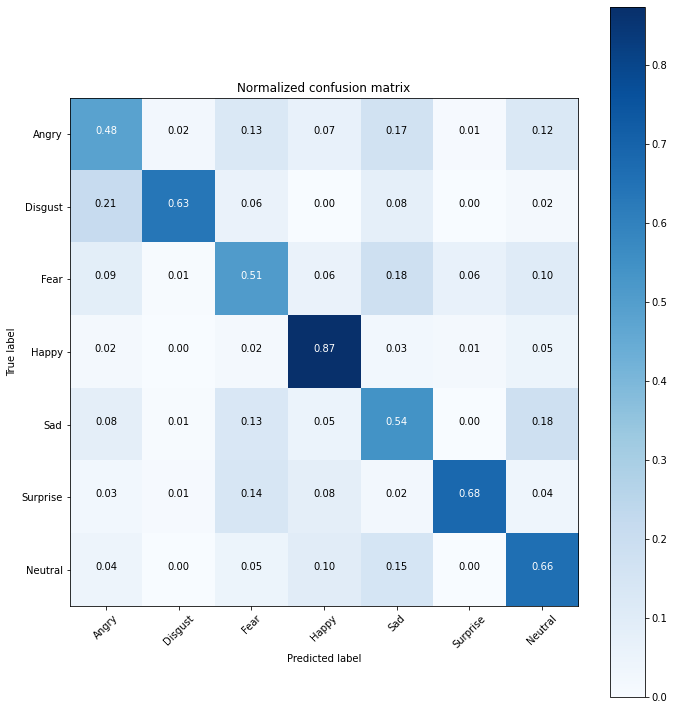

In [50]:
confusion(model)

In [51]:
def predict(img, model):
    full_size_image = cv2.imread(img)
    print("Image Loaded")
    gray=cv2.cvtColor(full_size_image,cv2.COLOR_BGR2GRAY)
    cv2.imwrite("a.png", gray)
    face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    print(faces)
    image = full_size_image
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    #detecting faces
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        yhat= model.predict(roi_gray[np.newaxis, :, :, np.newaxis])
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        # cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        # cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #predicting the emotion
        
        # print(np.argmax(yhat), yhat)
        # print("Emotion: "+labels[int(np.argmax(yhat))])
        plt.figure()
        plt.imshow(full_size_image)
        plt.show()
        print("Emotion: "+labels[int(np.argmax(yhat))])

Image Loaded
[[ 97  31  79  79]
 [201  43  69  69]]


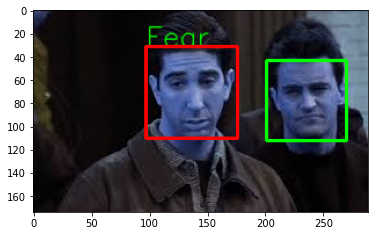

Emotion: Fear


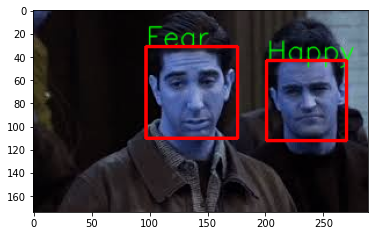

Emotion: Happy


In [57]:
predict('sad.jpeg', model)